## Avances Laboratorio #3 
##### Data Science  -  Universidad del Valle de Guatemala

- Gustavo Andres Gonzalez Pineda 21438
- Maria Marta Ramirez Gil 21342

--------------------------------------------------------------------------------------- 

Importamos las librerías necesarias para manipulación de datos, visualización, y creación de modelos LSTM.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

# Configuración inicial para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Cargar los datos
consumo = pd.read_csv('data/CONSUMO.csv')
importacion = pd.read_csv('data/IMPORTACION.csv')
precios = pd.read_csv('data/PRECIOS.csv')

# Mostrar una vista previa de los datos
print("CONSUMO")
display(consumo)
print()
print ("--------------------------------------------------------")
print("IMPORTACION")
display(importacion)
print()
print ("--------------------------------------------------------")
print("PRECIOS")
display(precios)

CONSUMO


,Fecha,GasLicuado,Regular,Superior,Diesel,GasLicuado_log,GasLicuado_diff,Diesel_log,Diesel_diff,Regular_log,Regular_diff,Superior_log,Superior_diff
0,2000-01-01,194410.48,202645.20,308156.82,634667.06,12.177727,NaN,13.360856,NaN,12.219212,NaN,12.638364,NaN
1,2000-02-01,174710.55,205530.96,307766.31,642380.66,12.070886,-0.106841,13.372936,0.012081,12.233352,0.014140,12.637096,-0.001268
2,2000-03-01,189234.07,229499.56,331910.29,699807.25,12.150740,0.079854,13.458560,0.085624,12.343656,0.110304,12.712620,0.075524
3,2000-04-01,174330.61,210680.40,315648.08,586803.98,12.068709,-0.082031,13.282446,-0.176114,12.258098,-0.085559,12.662383,-0.050237
4,2000-05-01,191745.15,208164.34,319667.97,656948.20,12.163922,0.095214,13.395360,0.112914,12.246083,-0.012014,12.675038,0.012655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-01-01,548124.45,830708.13,658083.66,1371766.15,13.214258,0.012597,14.131610,0.019500,13.630034,-0.057908,13.397087,-0.049371
289,2024-02-01,526897.85,818740.16,654059.60,1352602.93,13.174762,-0.039496,14.117541,-0.014068,13.615522,-0.014512,13.390954,-0.006134
290,2024-03-01,523990.91,870771.70,671997.05,1405703.42,13.169230,-0.005532,14.156048,0.038507,13.677135,0.061613,13.418009,0.027055
291,2024-04-01,531880.19,847353.15,633520.57,1442103.60,13.184174,0.014944,14.181613,0.025565,13.649873,-0.027262,13.359048,-0.058961



--------------------------------------------------------
IMPORTACION


,Fecha,GasLicuado,Regular,Superior,Diesel,GasLicuado_log,GasLicuado_diff,Diesel_log,Diesel_diff,Regular_log,Regular_diff
0,2001-01-01,194065.74,177776.50,373963.96,566101.99,12.175952,NaN,13.246530,NaN,12.088282,NaN
1,2001-02-01,170703.38,123115.99,243091.07,489525.80,12.047683,-0.128270,13.101192,-0.145337,11.720882,-0.367400
2,2001-03-01,161837.37,161726.42,312084.38,575559.68,11.994347,-0.053335,13.263098,0.161906,11.993661,0.272779
3,2001-04-01,163048.64,127338.74,285054.89,437745.42,12.001804,0.007457,12.989393,-0.273705,11.754606,-0.239055
4,2001-05-01,171518.86,168730.19,300913.67,552609.13,12.052449,0.050645,13.222406,0.233013,12.036056,0.281450
...,...,...,...,...,...,...,...,...,...,...,...
276,2024-01-01,701570.80,914133.32,712333.33,1415808.13,13.461077,0.013473,14.163211,-0.079257,13.725732,0.179730
277,2024-02-01,916541.70,740662.25,650360.11,1241501.08,13.728363,0.267286,14.031832,-0.131379,13.515300,-0.210432
278,2024-03-01,675157.48,838270.93,620077.74,1482045.48,13.422701,-0.305662,14.208934,0.177102,13.639097,0.123797
279,2024-04-01,473940.66,886132.77,687017.96,1294706.12,13.068837,-0.353864,14.073794,-0.135139,13.694622,0.055525



--------------------------------------------------------
PRECIOS


,Fecha,Superior,Regular,Diesel,GasLicuado,Diesel_log,Diesel_diff
0,2021-01-01,21.91,21.11,17.61,99.00,2.868467,NaN
1,2021-02-01,23.57,22.77,18.57,116.00,2.921547,0.053080
2,2021-03-01,25.85,25.05,20.86,116.00,3.037833,0.116286
3,2021-04-01,26.35,25.56,20.80,120.00,3.034953,-0.002880
4,2021-05-01,27.27,26.49,20.87,120.00,3.038313,0.003360
5,2021-06-01,28.01,27.22,22.29,120.00,3.104138,0.065825
6,2021-07-01,27.60,26.80,21.81,120.00,3.082369,-0.021770
7,2021-08-01,28.09,27.29,22.10,120.00,3.095578,0.013209
8,2021-09-01,28.79,27.99,22.79,120.00,3.126322,0.030744
9,2021-10-01,29.29,28.59,23.79,132.00,3.169265,0.042943


Vamos a limpiar las variables que no son estacionarias y reemplazarlas con sus respectivas variables estacionarias. Esto para obtener dataframes limpios.

In [2]:
# CONSUMO.csv
# botar las columnas GasLicuado, Diesel, Regular, Superior, GasLicuado_log, Diesel_log, Regular_log, Superior_log
consumo = consumo.drop(columns=['GasLicuado', 'Diesel', 'Regular', 'Superior', 'GasLicuado_log', 'Diesel_log', 'Regular_log', 'Superior_log'])
# renombrar las columnas
consumo = consumo.rename(columns={'GasLicuado_diff': 'GasLicuado', 'Diesel_diff': 'Diesel', 'Regular_diff': 'Regular', 'Superior_diff': 'Superior'})
print("CONSUMO")
display(consumo)
print()
print ("--------------------------------------------------------")

# IMPORTACION.csv
# botar las columnas GasLicuado_log, GasLicuado, Diesel_log, Diesel, Regular_log, Regular
importacion = importacion.drop(columns=['GasLicuado_log', 'GasLicuado', 'Diesel_log', 'Diesel', 'Regular_log', 'Regular'])
# renombrar las columnas
importacion = importacion.rename(columns={'GasLicuado_diff': 'GasLicuado', 'Diesel_diff': 'Diesel', 'Regular_diff': 'Regular'})
print("IMPORTACION")
display(importacion)
print()
print ("--------------------------------------------------------")

# PRECIOS.csv
# botar las columnas Diesel_log, Diesel
precios = precios.drop(columns=['Diesel_log', 'Diesel'])
# renombrar las columnas
precios = precios.rename(columns={'Diesel_diff': 'Diesel'})
print("PRECIOS")
display(precios)

CONSUMO


,Fecha,GasLicuado,Diesel,Regular,Superior
0,2000-01-01,NaN,NaN,NaN,NaN
1,2000-02-01,-0.106841,0.012081,0.014140,-0.001268
2,2000-03-01,0.079854,0.085624,0.110304,0.075524
3,2000-04-01,-0.082031,-0.176114,-0.085559,-0.050237
4,2000-05-01,0.095214,0.112914,-0.012014,0.012655
...,...,...,...,...,...
288,2024-01-01,0.012597,0.019500,-0.057908,-0.049371
289,2024-02-01,-0.039496,-0.014068,-0.014512,-0.006134
290,2024-03-01,-0.005532,0.038507,0.061613,0.027055
291,2024-04-01,0.014944,0.025565,-0.027262,-0.058961



--------------------------------------------------------
IMPORTACION


,Fecha,Superior,GasLicuado,Diesel,Regular
0,2001-01-01,373963.96,NaN,NaN,NaN
1,2001-02-01,243091.07,-0.128270,-0.145337,-0.367400
2,2001-03-01,312084.38,-0.053335,0.161906,0.272779
3,2001-04-01,285054.89,0.007457,-0.273705,-0.239055
4,2001-05-01,300913.67,0.050645,0.233013,0.281450
...,...,...,...,...,...
276,2024-01-01,712333.33,0.013473,-0.079257,0.179730
277,2024-02-01,650360.11,0.267286,-0.131379,-0.210432
278,2024-03-01,620077.74,-0.305662,0.177102,0.123797
279,2024-04-01,687017.96,-0.353864,-0.135139,0.055525



--------------------------------------------------------
PRECIOS


,Fecha,Superior,Regular,GasLicuado,Diesel
0,2021-01-01,21.91,21.11,99.00,NaN
1,2021-02-01,23.57,22.77,116.00,0.053080
2,2021-03-01,25.85,25.05,116.00,0.116286
3,2021-04-01,26.35,25.56,120.00,-0.002880
4,2021-05-01,27.27,26.49,120.00,0.003360
5,2021-06-01,28.01,27.22,120.00,0.065825
6,2021-07-01,27.60,26.80,120.00,-0.021770
7,2021-08-01,28.09,27.29,120.00,0.013209
8,2021-09-01,28.79,27.99,120.00,0.030744
9,2021-10-01,29.29,28.59,132.00,0.042943


### Manejo de valores faltantes

In [4]:
# Manejo de valores faltantes
# CONSUMO.csv
# Reemplazar los valores faltantes con el promedio de la columna para las columnas GasLicuado, Diesel, Regular, Superior
consumo['GasLicuado'] = consumo['GasLicuado'].fillna(consumo['GasLicuado'].mean())
consumo['Diesel'] = consumo['Diesel'].fillna(consumo['Diesel'].mean())
consumo['Regular'] = consumo['Regular'].fillna(consumo['Regular'].mean())
consumo['Superior'] = consumo['Superior'].fillna(consumo['Superior'].mean())

# IMPORTACION.csv
importacion['GasLicuado'] = importacion['GasLicuado'].fillna(importacion['GasLicuado'].mean())
importacion['Diesel'] = importacion['Diesel'].fillna(importacion['Diesel'].mean())
importacion['Regular'] = importacion['Regular'].fillna(importacion['Regular'].mean())
importacion['Superior'] = importacion['Superior'].fillna(importacion['Superior'].mean())

# PRECIOS.csv
precios['GasLicuado'] = precios['GasLicuado'].fillna(precios['GasLicuado'].mean())
precios['Diesel'] = precios['Diesel'].fillna(precios['Diesel'].mean())
precios['Regular'] = precios['Regular'].fillna(precios['Regular'].mean())
precios['Superior'] = precios['Superior'].fillna(precios['Superior'].mean())


# Verificar si hay valores faltantes
print("CONSUMO")
print(consumo.isnull().sum())
print()
print ("--------------------------------------------------------")
print("IMPORTACION")
print(importacion.isnull().sum())
print()
print ("--------------------------------------------------------")  
print("PRECIOS")
print(precios.isnull().sum()) 

CONSUMO
Fecha         0
GasLicuado    0
Diesel        0
Regular       0
Superior      0
dtype: int64

--------------------------------------------------------
IMPORTACION
Fecha         0
Superior      0
GasLicuado    0
Diesel        0
Regular       0
dtype: int64

--------------------------------------------------------
PRECIOS
Fecha         0
Superior      0
Regular       0
GasLicuado    0
Diesel        0
dtype: int64


## Visualizacion de las series
Usar las variables ya estacionarias

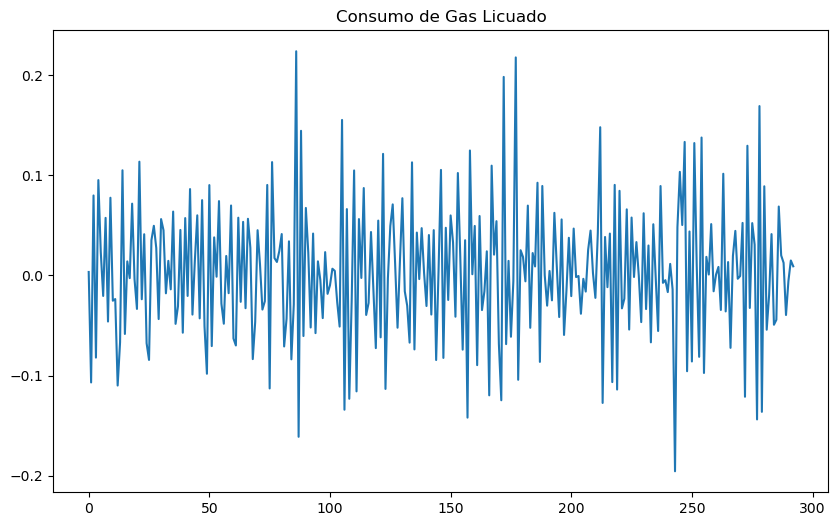

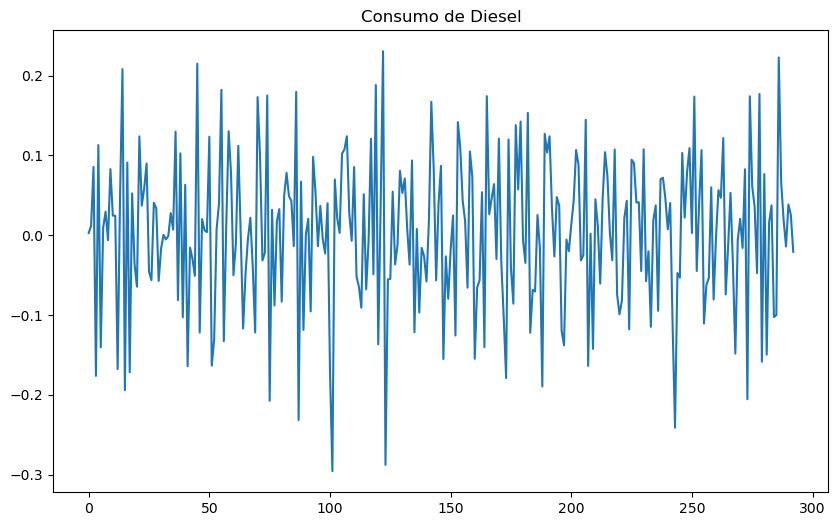

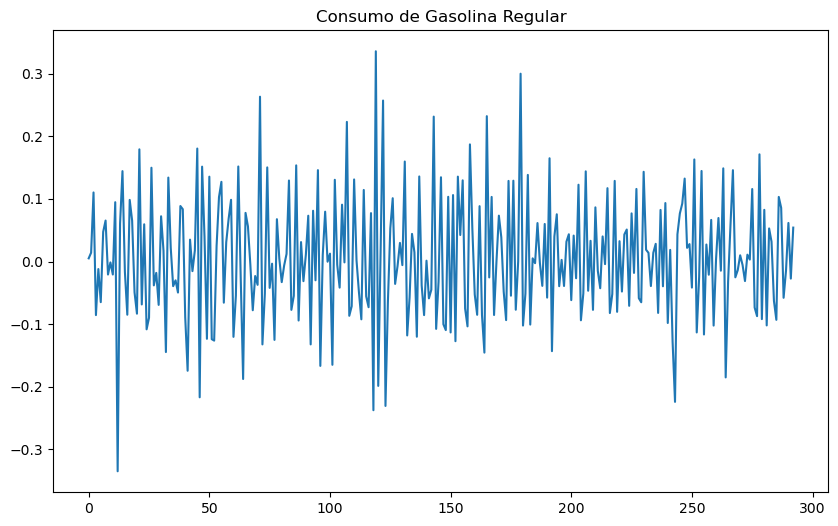

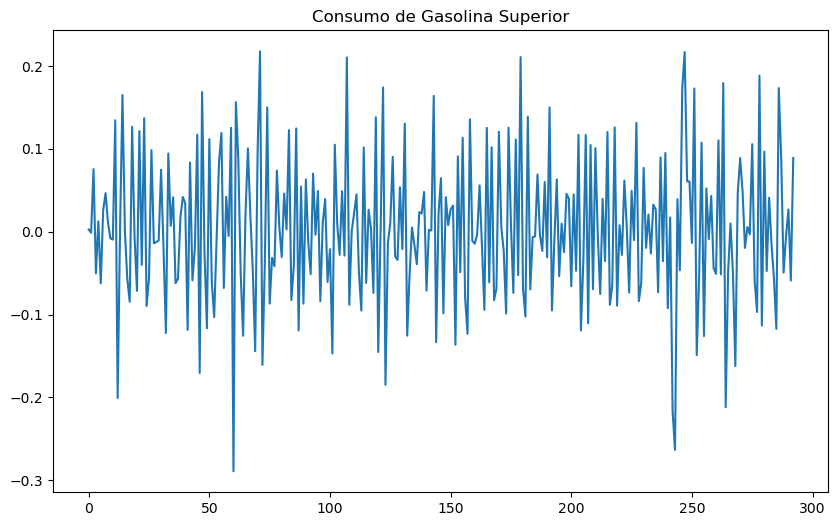

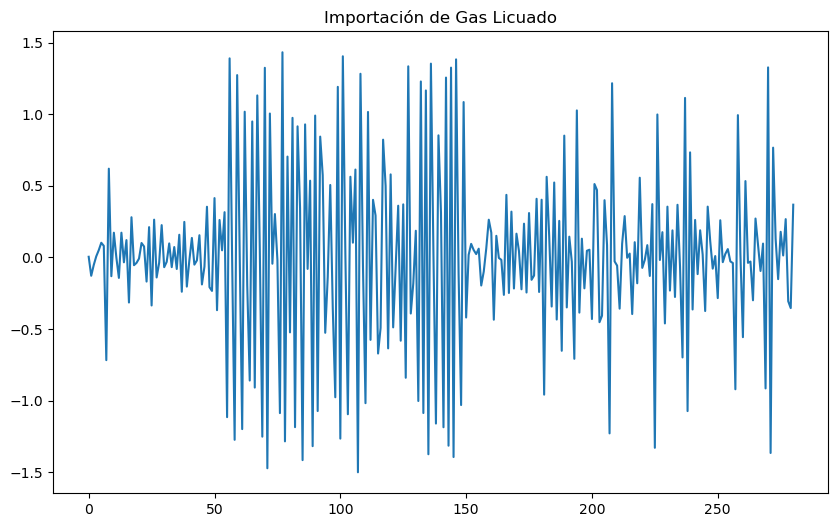

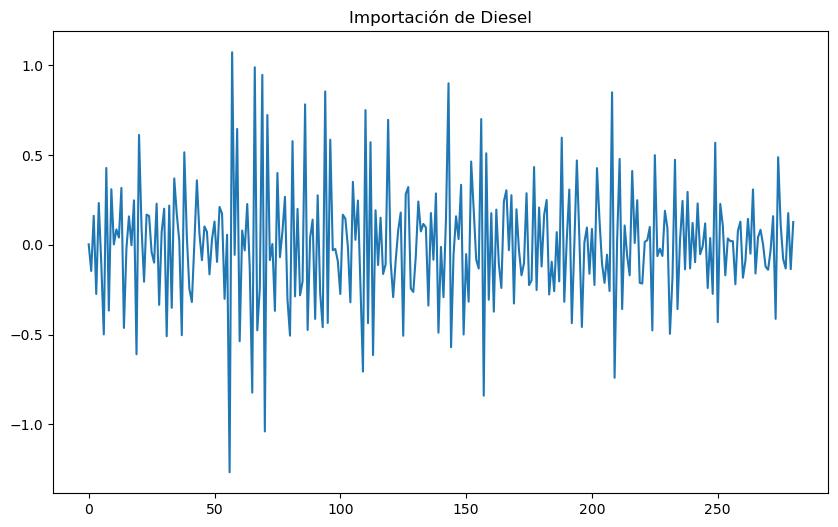

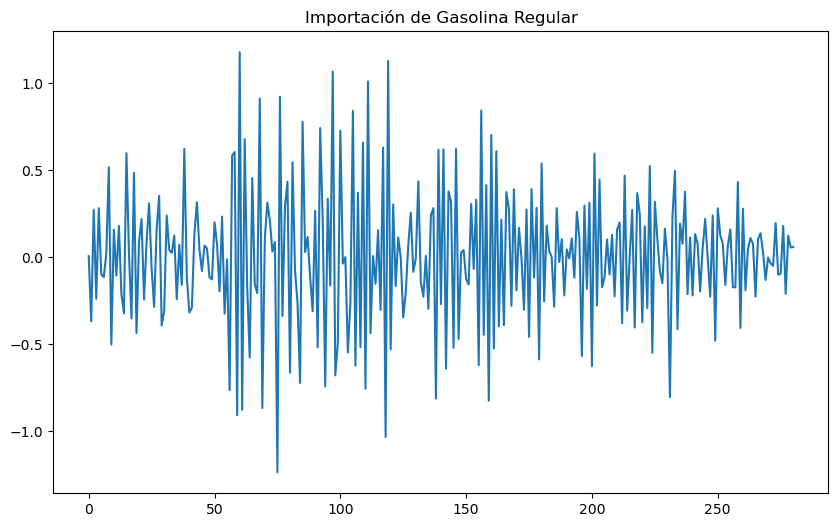

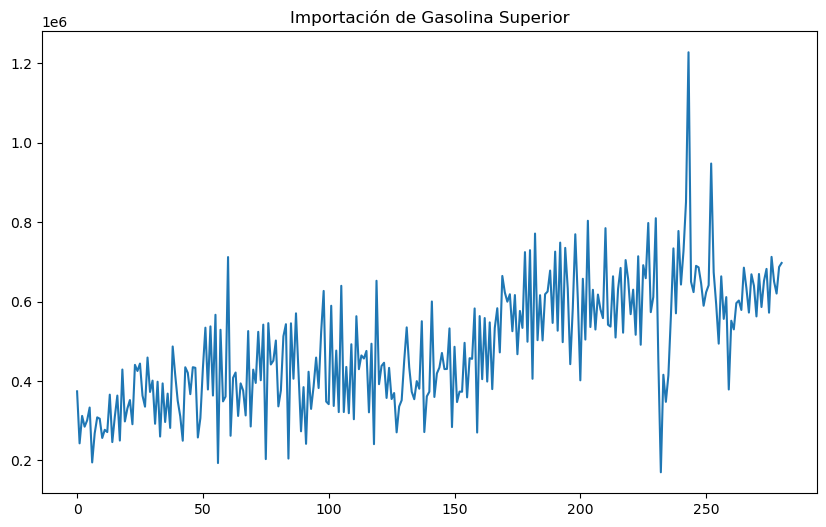

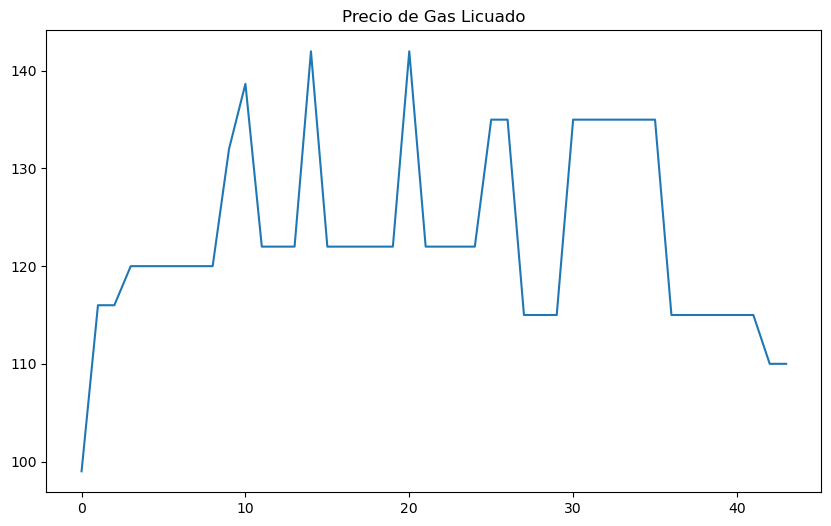

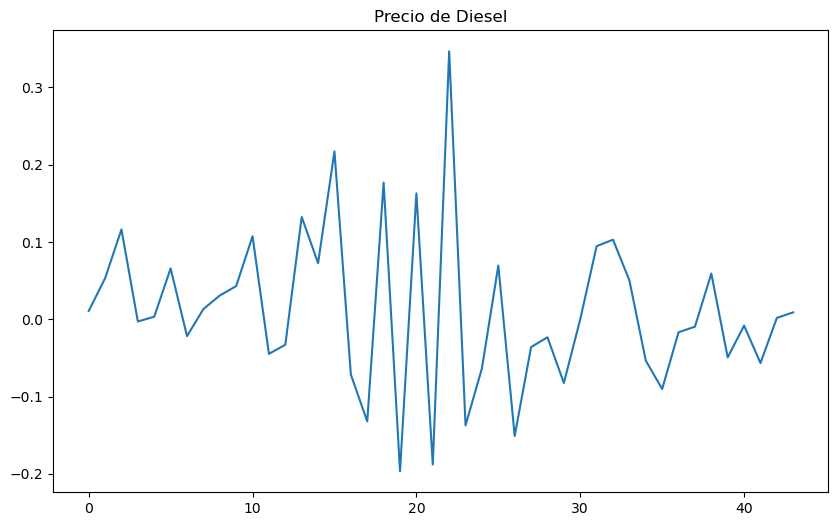

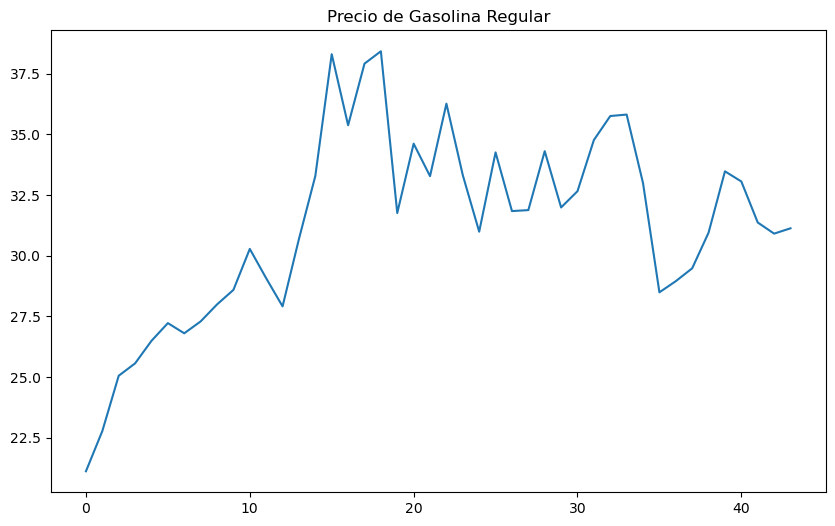

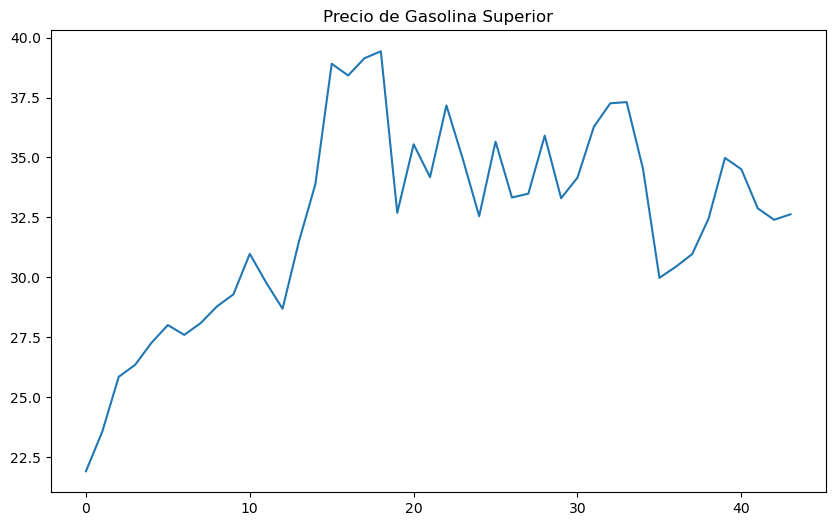

In [5]:
def plot_series(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data)
    plt.title(title)
    plt.show()

plot_series(consumo['GasLicuado'], 'Consumo de Gas Licuado')
plot_series(consumo['Diesel'], 'Consumo de Diesel')
plot_series(consumo['Regular'], 'Consumo de Gasolina Regular')
plot_series(consumo['Superior'], 'Consumo de Gasolina Superior')

plot_series(importacion['GasLicuado'], 'Importación de Gas Licuado')
plot_series(importacion['Diesel'], 'Importación de Diesel')
plot_series(importacion['Regular'], 'Importación de Gasolina Regular')
plot_series(importacion['Superior'], 'Importación de Gasolina Superior')

plot_series(precios['GasLicuado'], 'Precio de Gas Licuado')
plot_series(precios['Diesel'], 'Precio de Diesel')
plot_series(precios['Regular'], 'Precio de Gasolina Regular')
plot_series(precios['Superior'], 'Precio de Gasolina Superior')

## Procesamiento de Datos
Para trabajar con modelos LSTM, es necesario escalar los datos. Usamos StandardScaler para normalizar las series de tiempo.

In [6]:
scaler = StandardScaler()

# Escalar solo los datos numéricos
consumo_scaled = scaler.fit_transform(consumo[['GasLicuado', 'Diesel', 'Regular', 'Superior']])
importacion_scaled = scaler.fit_transform(importacion[['GasLicuado', 'Diesel', 'Regular', 'Superior']])
precios_scaled = scaler.fit_transform(precios[['GasLicuado', 'Diesel', 'Regular', 'Superior']])

### Secuencia de datos
Definimos una función para convertir las series de tiempo en secuencias de datos que serán usadas como entrada para el modelo LSTM.

In [7]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 12  # Definimos una ventana de tiempo de 12 meses (1 año)

X_consumo_gas_licuado, y_consumo_gas_licuado = create_sequences(consumo_scaled[:, 0], seq_length)
X_importacion_gas_licuado, y_importacion_gas_licuado = create_sequences(importacion_scaled[:, 0], seq_length)
X_precios_gas_licuado, y_precios_gas_licuado = create_sequences(precios_scaled[:, 0], seq_length)

X_consumo_diesel, y_consumo_diesel = create_sequences(consumo_scaled[:, 1], seq_length)
X_importacion_diesel, y_importacion_diesel = create_sequences(importacion_scaled[:, 1], seq_length)
X_precios_diesel, y_precios_diesel = create_sequences(precios_scaled[:, 1], seq_length)

X_consumo_regular, y_consumo_regular = create_sequences(consumo_scaled[:, 2], seq_length)
X_importacion_regular, y_importacion_regular = create_sequences(importacion_scaled[:, 2], seq_length)
X_precios_regular, y_precios_regular = create_sequences(precios_scaled[:, 2], seq_length)

X_consumo_superior, y_consumo_superior = create_sequences(consumo_scaled[:, 3], seq_length)
X_importacion_superior, y_importacion_superior = create_sequences(importacion_scaled[:, 3], seq_length)
X_precios_superior, y_precios_superior = create_sequences(precios_scaled[:, 3], seq_length)

# SERIE CONSUMO

### Division de conjunto de datos
Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [8]:
train_size = int(len(X_consumo_gas_licuado) * 0.8)

# Gas Licuado
X_train_consumo_gas_licuado, X_test_consumo_gas_licuado = X_consumo_gas_licuado[:train_size], X_consumo_gas_licuado[train_size:]
y_train_consumo_gas_licuado, y_test_consumo_gas_licuado = y_consumo_gas_licuado[:train_size], y_consumo_gas_licuado[train_size:]

# Diesel
X_train_consumo_diesel, X_test_consumo_diesel = X_consumo_diesel[:train_size], X_consumo_diesel[train_size:]
y_train_consumo_diesel, y_test_consumo_diesel = y_consumo_diesel[:train_size], y_consumo_diesel[train_size:]

# Regular
X_train_consumo_regular, X_test_consumo_regular = X_consumo_regular[:train_size], X_consumo_regular[train_size:]
y_train_consumo_regular, y_test_consumo_regular = y_consumo_regular[:train_size], y_consumo_regular[train_size:]

# Superior
X_train_consumo_superior, X_test_consumo_superior = X_consumo_superior[:train_size], X_consumo_superior[train_size:]
y_train_consumo_superior, y_test_consumo_superior = y_consumo_superior[:train_size], y_consumo_superior[train_size:]


## Modelo LSTM #1 para la serie CONSUMO
Definimos una función para crear un modelo LSTM con una arquitectura básica. Esta se usara con las demas series como Modelo #1.

In [9]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

#### Entrenamiento para todos los combustibles
Entrenamos el modelo LSTM usando los datos de consumo.

In [20]:
# ya que el array es en 2D ajustamos la forma para que sea compatible con el modelo LSTM

# Gas Licuado
if len(X_train_consumo_gas_licuado.shape) == 2:
    X_train_consumo_gas_licuado = np.expand_dims(X_train_consumo_gas_licuado, axis=-1)
    X_test_consumo_gas_licuado = np.expand_dims(X_test_consumo_gas_licuado, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_gas_licuado: {X_train_consumo_gas_licuado.shape}")

# Diesel
if len(X_train_consumo_diesel.shape) == 2:
    X_train_consumo_diesel = np.expand_dims(X_train_consumo_diesel, axis=-1)
    X_test_consumo_diesel = np.expand_dims(X_test_consumo_diesel, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_diesel: {X_train_consumo_diesel.shape}")

# Regular
if len(X_train_consumo_regular.shape) == 2:
    X_train_consumo_regular = np.expand_dims(X_train_consumo_regular, axis=-1)
    X_test_consumo_regular = np.expand_dims(X_test_consumo_regular, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_regular: {X_train_consumo_regular.shape}")

# Superior
if len(X_train_consumo_superior.shape) == 2:
    X_train_consumo_superior = np.expand_dims(X_train_consumo_superior, axis=-1)
    X_test_consumo_superior = np.expand_dims(X_test_consumo_superior, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_superior: {X_train_consumo_superior.shape}")

Nuevas dimensiones de X_train_consumo_gas_licuado: (224, 12, 1)
Nuevas dimensiones de X_train_consumo_diesel: (224, 12, 1)
Nuevas dimensiones de X_train_consumo_regular: (224, 12, 1)
Nuevas dimensiones de X_train_consumo_superior: (224, 12, 1)


In [13]:
# Entrenamiento Gas Licuado
model_consumo_gas_licuado = create_lstm_model((X_train_consumo_gas_licuado.shape[1], X_train_consumo_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_gas_licuado = model_consumo_gas_licuado.fit(X_train_consumo_gas_licuado, y_train_consumo_gas_licuado, epochs=100, validation_data=(X_test_consumo_gas_licuado, y_test_consumo_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 110ms/step - loss: 0.9609 - val_loss: 1.1861
Epoch 2/100
7/7 [==============================] - 0s 31ms/step - loss: 0.9552 - val_loss: 1.1818
Epoch 3/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9527 - val_loss: 1.1795
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9517 - val_loss: 1.1777
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9479 - val_loss: 1.1744
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9451 - val_loss: 1.1707
Epoch 7/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9430 - val_loss: 1.1658
Epoch 8/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9403 - val_loss: 1.1616
Epoch 9/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9318 - val_loss: 1.1501
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9193 - val_loss: 1.1315
Epoch 11/100
7/7 [

In [21]:
# Entrenamiento Diesel
model_consumo_diesel = create_lstm_model((X_train_consumo_diesel.shape[1], X_train_consumo_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_diesel = model_consumo_diesel.fit(X_train_consumo_diesel, y_train_consumo_diesel, epochs=100, validation_data=(X_test_consumo_diesel, y_test_consumo_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 102ms/step - loss: 1.0174 - val_loss: 0.9963
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 1.0059 - val_loss: 0.9870
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9990 - val_loss: 0.9802
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9888 - val_loss: 0.9682
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9782 - val_loss: 0.9522
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 0.9645 - val_loss: 0.9364
Epoch 7/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9339 - val_loss: 0.8976
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 0.8919 - val_loss: 0.8475
Epoch 9/100
7/7 [==============================] - 0s 17ms/step - loss: 0.8533 - val_loss: 0.8770
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.8424 - val_loss: 0.8450
Epoch 11/100
7/7 [

In [22]:
# Entrenamiento Regular
model_consumo_regular = create_lstm_model((X_train_consumo_regular.shape[1], X_train_consumo_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_regular = model_consumo_regular.fit(X_train_consumo_regular, y_train_consumo_regular, epochs=100, validation_data=(X_test_consumo_regular, y_test_consumo_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 100ms/step - loss: 1.0939 - val_loss: 0.7951
Epoch 2/100
7/7 [==============================] - 0s 19ms/step - loss: 1.0877 - val_loss: 0.7910
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 1.0819 - val_loss: 0.7900
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 1.0791 - val_loss: 0.7880
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 1.0768 - val_loss: 0.7855
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 1.0738 - val_loss: 0.7837
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 1.0682 - val_loss: 0.7809
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0618 - val_loss: 0.7770
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 1.0533 - val_loss: 0.7665
Epoch 10/100
7/7 [==============================] - 0s 19ms/step - loss: 1.0228 - val_loss: 0.7458
Epoch 11/100
7/7 [

In [23]:
# Entrenamiento Superior
model_consumo_superior = create_lstm_model((X_train_consumo_superior.shape[1], X_train_consumo_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_superior = model_consumo_superior.fit(X_train_consumo_superior, y_train_consumo_superior, epochs=100, validation_data=(X_test_consumo_superior, y_test_consumo_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 132ms/step - loss: 0.9397 - val_loss: 1.3900
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 0.9350 - val_loss: 1.3829
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 0.9300 - val_loss: 1.3803
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.9263 - val_loss: 1.3762
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 0.9213 - val_loss: 1.3709
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.9128 - val_loss: 1.3663
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.8981 - val_loss: 1.3642
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 0.8676 - val_loss: 1.3652
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 0.7909 - val_loss: 2.1337
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 0.7179 - val_loss: 3.9398
Epoch 11/100
7/7 [

#### Perdida
Graficamos la pérdida (loss) durante el entrenamiento para evaluar el rendimiento del modelo.

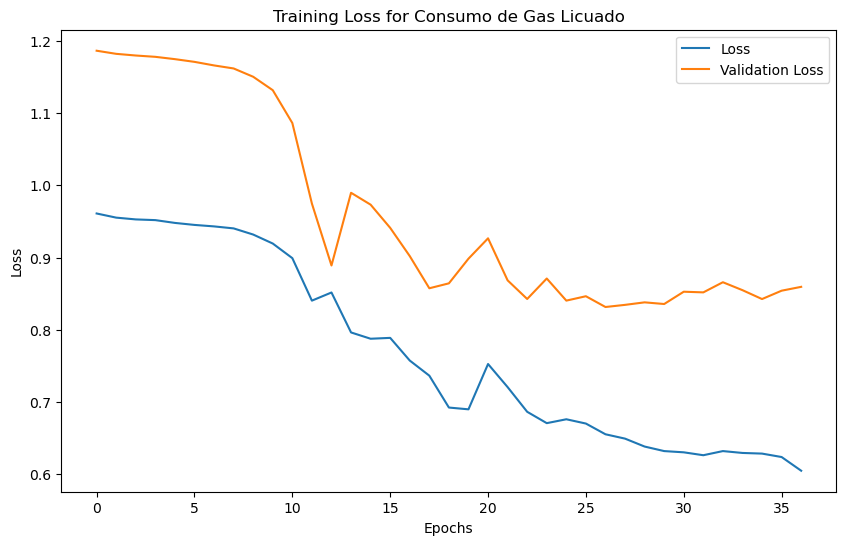

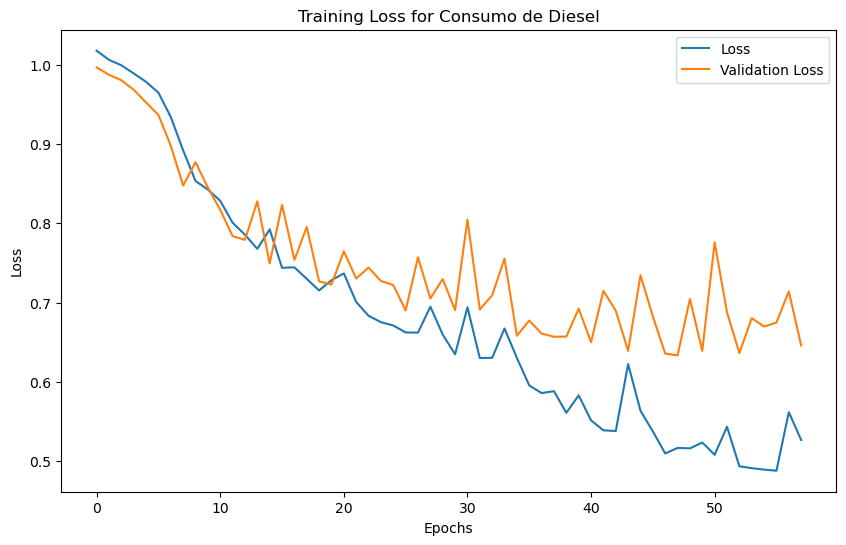

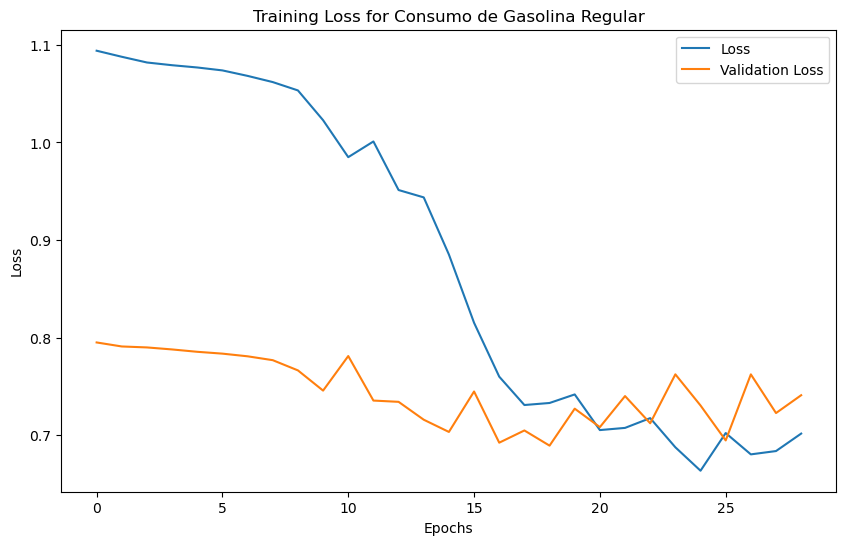

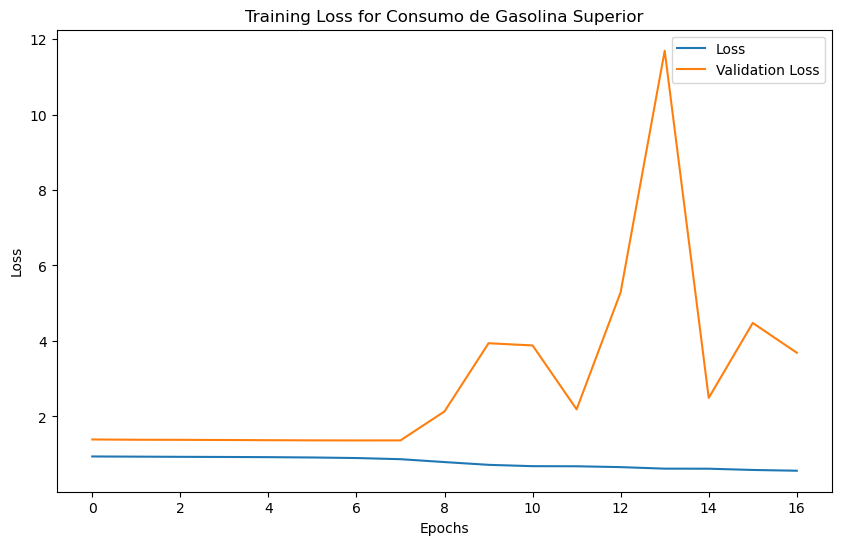

In [24]:
# Perdida de Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_gas_licuado.history['loss'], label='Loss')
plt.plot(history_consumo_gas_licuado.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gas Licuado')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida de Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_diesel.history['loss'], label='Loss')
plt.plot(history_consumo_diesel.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()  

# Perdida de Regular
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_regular.history['loss'], label='Loss')
plt.plot(history_consumo_regular.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida de Superior
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_superior.history['loss'], label='Loss')
plt.plot(history_consumo_superior.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gasolina Superior') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluacion del Modelo
Evaluamos el modelo utilizando la métrica de Root Mean Squared Error (RMSE).

In [25]:
# Evaluacion modelo Gas Licuado
y_pred_consumo_gas_licuado = model_consumo_gas_licuado.predict(X_test_consumo_gas_licuado)
rmse_consumo_gas_licuado = np.sqrt(mean_squared_error(y_test_consumo_gas_licuado, y_pred_consumo_gas_licuado))
print(f'RMSE for Consumo de Gas Licuado: {rmse_consumo_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_consumo_diesel = model_consumo_diesel.predict(X_test_consumo_diesel)
rmse_consumo_diesel = np.sqrt(mean_squared_error(y_test_consumo_diesel, y_pred_consumo_diesel)) 
print(f'RMSE for Consumo de Diesel: {rmse_consumo_diesel}')
print()

# Evaluacion modelo Regular
y_pred_consumo_regular = model_consumo_regular.predict(X_test_consumo_regular)
rmse_consumo_regular = np.sqrt(mean_squared_error(y_test_consumo_regular, y_pred_consumo_regular))
print(f'RMSE for Consumo de Gasolina Regular: {rmse_consumo_regular}')
print()

# Evaluacion modelo Superior
y_pred_consumo_superior = model_consumo_superior.predict(X_test_consumo_superior)
rmse_consumo_superior = np.sqrt(mean_squared_error(y_test_consumo_superior, y_pred_consumo_superior))
print(f'RMSE for Consumo de Gasolina Superior: {rmse_consumo_superior}')    


2/2 [==============================] - 0s 6ms/step
RMSE for Consumo de Gas Licuado: 0.9118794443393086

2/2 [==============================] - 0s 8ms/step
RMSE for Consumo de Diesel: 0.795967929212186

2/2 [==============================] - 0s 7ms/step
RMSE for Consumo de Gasolina Regular: 0.8303229991156887

2/2 [==============================] - 0s 5ms/step
RMSE for Consumo de Gasolina Superior: 1.1679961599096778


### Tuneo de parámetros
Implementamos un tuneo de parámetros variando el número de unidades en las capas LSTM y la tasa de aprendizaje del optimizador.

In [17]:
def tune_lstm_model(X_train, y_train, X_test, y_test, units_list, learning_rates):
    best_rmse = float('inf')
    best_model = None
    for units in units_list:
        for lr in learning_rates:
            model = Sequential()
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
            model.add(LSTM(units, activation='relu'))
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
    return best_model

Aplicar el Tuneo de Parámetros a la Serie de Consumo

In [18]:
# Tuneo Gas Licuado
best_model_consumo_gas_licuado = tune_lstm_model(X_train_consumo_gas_licuado, y_train_consumo_gas_licuado, X_test_consumo_gas_licuado, y_test_consumo_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 97ms/step - loss: 0.9612 - val_loss: 1.1869
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.9562 - val_loss: 1.1832
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9536 - val_loss: 1.1805
Epoch 4/50
7/7 [==============================] - 0s 31ms/step - loss: 0.9521 - val_loss: 1.1784
Epoch 5/50
7/7 [==============================] - 0s 21ms/step - loss: 0.9483 - val_loss: 1.1747
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 0.9449 - val_loss: 1.1704
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9418 - val_loss: 1.1641
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9377 - val_loss: 1.1577
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9261 - val_loss: 1.1386
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9028 - val_loss: 1.0926
Epoch 11/50
7/7 [============

In [26]:
# Tuneo Diesel
best_model_consumo_diesel = tune_lstm_model(X_train_consumo_diesel, y_train_consumo_diesel, X_test_consumo_diesel, y_test_consumo_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 100ms/step - loss: 1.0180 - val_loss: 0.9975
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 1.0075 - val_loss: 0.9895
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 1.0022 - val_loss: 0.9844
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9956 - val_loss: 0.9779
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9881 - val_loss: 0.9680
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9785 - val_loss: 0.9551
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9585 - val_loss: 0.9291
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9242 - val_loss: 0.8761
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.8695 - val_loss: 0.8670
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.8758 - val_loss: 0.8838
Epoch 11/50
7/7 [===========

In [27]:
# Tuneo Regular
best_model_consumo_regular = tune_lstm_model(X_train_consumo_regular, y_train_consumo_regular, X_test_consumo_regular, y_test_consumo_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 100ms/step - loss: 1.0959 - val_loss: 0.7975
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 1.0896 - val_loss: 0.7925
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0828 - val_loss: 0.7917
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0799 - val_loss: 0.7896
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0779 - val_loss: 0.7876
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0747 - val_loss: 0.7858
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 1.0681 - val_loss: 0.7829
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0606 - val_loss: 0.7792
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0515 - val_loss: 0.7718
Epoch 10/50
7/7 [==============================] - 0s 19ms/step - loss: 1.0249 - val_loss: 0.7669
Epoch 11/50
7/7 [===========

In [28]:
# Tuneo Superior
best_model_consumo_superior = tune_lstm_model(X_train_consumo_superior, y_train_consumo_superior, X_test_consumo_superior, y_test_consumo_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 97ms/step - loss: 0.9395 - val_loss: 1.3913
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.9360 - val_loss: 1.3852
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9332 - val_loss: 1.3835
Epoch 4/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9312 - val_loss: 1.3810
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9292 - val_loss: 1.3765
Epoch 6/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9259 - val_loss: 1.3732
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9217 - val_loss: 1.3697
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9156 - val_loss: 1.3644
Epoch 9/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9026 - val_loss: 1.3510
Epoch 10/50
7/7 [==============================] - 0s 20ms/step - loss: 0.8699 - val_loss: 1.4408
Epoch 11/50
7/7 [============

## Evaluacion
Utilizamos el mejor modelo para hacer predicciones y calculamos el RMSE.

In [29]:
# Evaluacion modelo Gas Licuado
y_pred_best_consumo_gas_licuado = best_model_consumo_gas_licuado.predict(X_test_consumo_gas_licuado)
best_rmse_consumo_gas_licuado = np.sqrt(mean_squared_error(y_test_consumo_gas_licuado, y_pred_best_consumo_gas_licuado))
print(f'Best RMSE for Consumo de Gas Licuado after tuning: {best_rmse_consumo_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_best_consumo_diesel = best_model_consumo_diesel.predict(X_test_consumo_diesel)
best_rmse_consumo_diesel = np.sqrt(mean_squared_error(y_test_consumo_diesel, y_pred_best_consumo_diesel))
print(f'Best RMSE for Consumo de Diesel after tuning: {best_rmse_consumo_diesel}')
print()

# Evaluacion modelo Regular
y_pred_best_consumo_regular = best_model_consumo_regular.predict(X_test_consumo_regular)
best_rmse_consumo_regular = np.sqrt(mean_squared_error(y_test_consumo_regular, y_pred_best_consumo_regular))
print(f'Best RMSE for Consumo de Gasolina Regular after tuning: {best_rmse_consumo_regular}')
print()

# Evaluacion modelo Superior
y_pred_best_consumo_superior = best_model_consumo_superior.predict(X_test_consumo_superior)
best_rmse_consumo_superior = np.sqrt(mean_squared_error(y_test_consumo_superior, y_pred_best_consumo_superior))
print(f'Best RMSE for Consumo de Gasolina Superior after tuning: {best_rmse_consumo_superior}')

2/2 [==============================] - 0s 7ms/step
Best RMSE for Consumo de Gas Licuado after tuning: 0.8940388348562487

2/2 [==============================] - 0s 16ms/step
Best RMSE for Consumo de Diesel after tuning: 0.7894927833349331

2/2 [==============================] - 0s 12ms/step
Best RMSE for Consumo de Gasolina Regular after tuning: 0.7914679715755282

2/2 [==============================] - 0s 6ms/step
Best RMSE for Consumo de Gasolina Superior after tuning: 1.1623421779334682


### Guardar Modelo para la Serie Consumo

In [64]:
# Guardar los modelos
best_model_consumo_gas_licuado.save('BestModels/CONSUMO-M1/best_model_consumo_gas_licuado.h5')
best_model_consumo_diesel.save('BestModels/CONSUMO-M1/best_model_consumo_diesel.h5')
best_model_consumo_regular.save('BestModels/CONSUMO-M1/best_model_consumo_regular.h5')
best_model_consumo_superior.save('BestModels/CONSUMO-M1/best_model_consumo_superior.h5')

## Modelo LSTM #2 para la serie CONSUMO
Definimos una función para crear un modelo LSTM con una arquitectura básica.... AQUI EMPEZAR EL MODELO 2

# SERIE IMPORTACION

### Division de conjunto de datos
Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [30]:
# Division de los datos de importacion
train_size = int(len(X_importacion_gas_licuado) * 0.8)

# Gas Licuado
X_train_importacion_gas_licuado, X_test_importacion_gas_licuado = X_importacion_gas_licuado[:train_size], X_importacion_gas_licuado[train_size:]
y_train_importacion_gas_licuado, y_test_importacion_gas_licuado = y_importacion_gas_licuado[:train_size], y_importacion_gas_licuado[train_size:]

# Diesel
X_train_importacion_diesel, X_test_importacion_diesel = X_importacion_diesel[:train_size], X_importacion_diesel[train_size:]
y_train_importacion_diesel, y_test_importacion_diesel = y_importacion_diesel[:train_size], y_importacion_diesel[train_size:]

# Regular
X_train_importacion_regular, X_test_importacion_regular = X_importacion_regular[:train_size], X_importacion_regular[train_size:]
y_train_importacion_regular, y_test_importacion_regular = y_importacion_regular[:train_size], y_importacion_regular[train_size:]

# Superior
X_train_importacion_superior, X_test_importacion_superior = X_importacion_superior[:train_size], X_importacion_superior[train_size:]
y_train_importacion_superior, y_test_importacion_superior = y_importacion_superior[:train_size], y_importacion_superior[train_size:]

#### Entrenamiento para todos los combustibles
Entrenamos el modelo LSTM usando los datos de importacion.

In [31]:
# ya que el array es en 2D ajustamos la forma para que sea compatible con el modelo LSTM

# Gas licuado
if len(X_train_importacion_gas_licuado.shape) == 2:
    X_train_importacion_gas_licuado = np.expand_dims(X_train_importacion_gas_licuado, axis=-1)
    X_test_importacion_gas_licuado = np.expand_dims(X_test_importacion_gas_licuado, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_gas_licuado: {X_train_importacion_gas_licuado.shape}")

# Diesel
if len(X_train_importacion_diesel.shape) == 2:
    X_train_importacion_diesel = np.expand_dims(X_train_importacion_diesel, axis=-1)
    X_test_importacion_diesel = np.expand_dims(X_test_importacion_diesel, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_diesel: {X_train_importacion_diesel.shape}")

# Regular
if len(X_train_importacion_regular.shape) == 2:
    X_train_importacion_regular = np.expand_dims(X_train_importacion_regular, axis=-1)
    X_test_importacion_regular = np.expand_dims(X_test_importacion_regular, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_regular: {X_train_importacion_regular.shape}")

# Superior
if len(X_train_importacion_superior.shape) == 2:
    X_train_importacion_superior = np.expand_dims(X_train_importacion_superior, axis=-1)
    X_test_importacion_superior = np.expand_dims(X_test_importacion_superior, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_superior: {X_train_importacion_superior.shape}")

Nuevas dimensiones de X_train_importacion_gas_licuado: (215, 12, 1)
Nuevas dimensiones de X_train_importacion_diesel: (215, 12, 1)
Nuevas dimensiones de X_train_importacion_regular: (215, 12, 1)
Nuevas dimensiones de X_train_importacion_superior: (215, 12, 1)


In [32]:
# Entrenamiento Gas Licuado
model_importacion_gas_licuado = create_lstm_model((X_train_importacion_gas_licuado.shape[1], X_train_importacion_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_gas_licuado = model_importacion_gas_licuado.fit(X_train_importacion_gas_licuado, y_train_importacion_gas_licuado, epochs=100, validation_data=(X_test_importacion_gas_licuado, y_test_importacion_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 101ms/step - loss: 1.1460 - val_loss: 0.6063
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 1.1395 - val_loss: 0.6053
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 1.1375 - val_loss: 0.6042
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1362 - val_loss: 0.6027
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1311 - val_loss: 0.6011
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1279 - val_loss: 0.5995
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1211 - val_loss: 0.5967
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1137 - val_loss: 0.5923
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 1.0980 - val_loss: 0.5833
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0616 - val_loss: 0.5588
Epoch 11/100
7/7 [

In [33]:
# Entrenamiento Diesel
model_importacion_diesel = create_lstm_model((X_train_importacion_diesel.shape[1], X_train_importacion_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_diesel = model_importacion_diesel.fit(X_train_importacion_diesel, y_train_importacion_diesel, epochs=100, validation_data=(X_test_importacion_diesel, y_test_importacion_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 5s 115ms/step - loss: 1.1705 - val_loss: 0.4118
Epoch 2/100
7/7 [==============================] - 0s 33ms/step - loss: 1.1651 - val_loss: 0.4110
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1610 - val_loss: 0.4101
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1583 - val_loss: 0.4092
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 1.1582 - val_loss: 0.4082
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1513 - val_loss: 0.4064
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 1.1455 - val_loss: 0.4045
Epoch 8/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1385 - val_loss: 0.4011
Epoch 9/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1215 - val_loss: 0.3951
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0755 - val_loss: 0.3768
Epoch 11/100
7/7 [

In [34]:
# Entrenamiento Regular
model_importacion_regular = create_lstm_model((X_train_importacion_regular.shape[1], X_train_importacion_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_regular = model_importacion_regular.fit(X_train_importacion_regular, y_train_importacion_regular, epochs=100, validation_data=(X_test_importacion_regular, y_test_importacion_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 98ms/step - loss: 1.1934 - val_loss: 0.3425
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 1.1864 - val_loss: 0.3419
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1829 - val_loss: 0.3419
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1816 - val_loss: 0.3409
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1769 - val_loss: 0.3402
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1739 - val_loss: 0.3390
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1670 - val_loss: 0.3373
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1550 - val_loss: 0.3331
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1305 - val_loss: 0.3239
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0369 - val_loss: 0.2929
Epoch 11/100
7/7 [=

In [35]:
# Entrenamiento Superior
model_importacion_superior = create_lstm_model((X_train_importacion_superior.shape[1], X_train_importacion_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_superior = model_importacion_superior.fit(X_train_importacion_superior, y_train_importacion_superior, epochs=100, validation_data=(X_test_importacion_superior, y_test_importacion_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 103ms/step - loss: 0.7016 - val_loss: 1.6021
Epoch 2/100
7/7 [==============================] - 0s 19ms/step - loss: 0.5930 - val_loss: 1.4595
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.4937 - val_loss: 1.2323
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 0.4297 - val_loss: 1.5257
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 0.4310 - val_loss: 1.9393
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.4163 - val_loss: 1.2831
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4160 - val_loss: 1.2635
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4166 - val_loss: 1.3503
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 0.4189 - val_loss: 1.3064
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4142 - val_loss: 1.3932
Epoch 11/100
7/7 [

#### Perdida
Graficamos la pérdida (loss) durante el entrenamiento para evaluar el rendimiento del modelo.

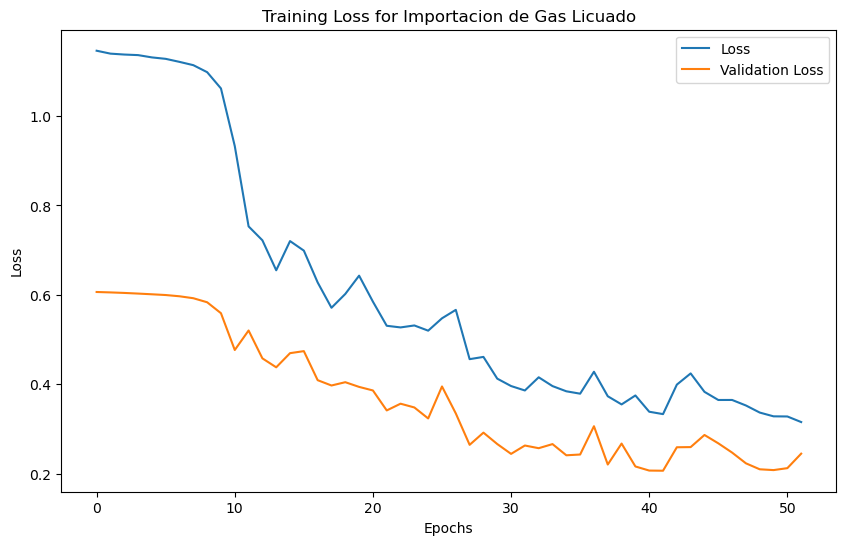

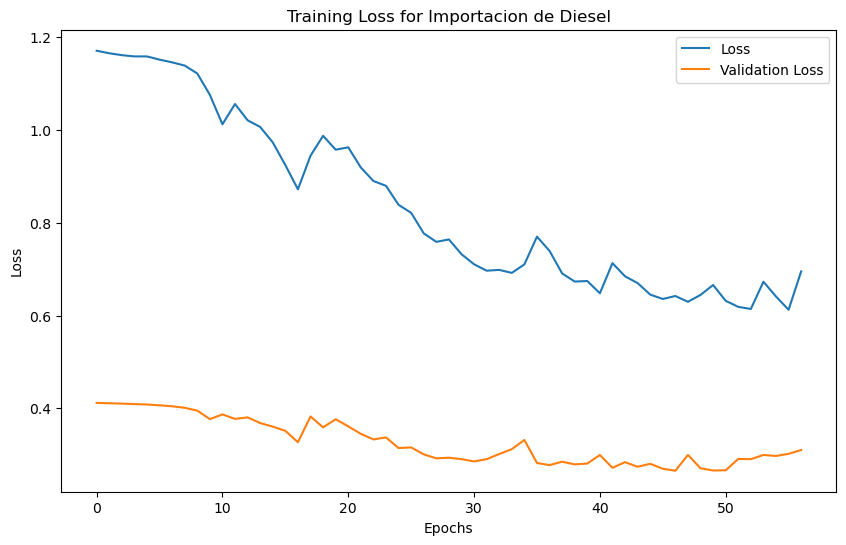

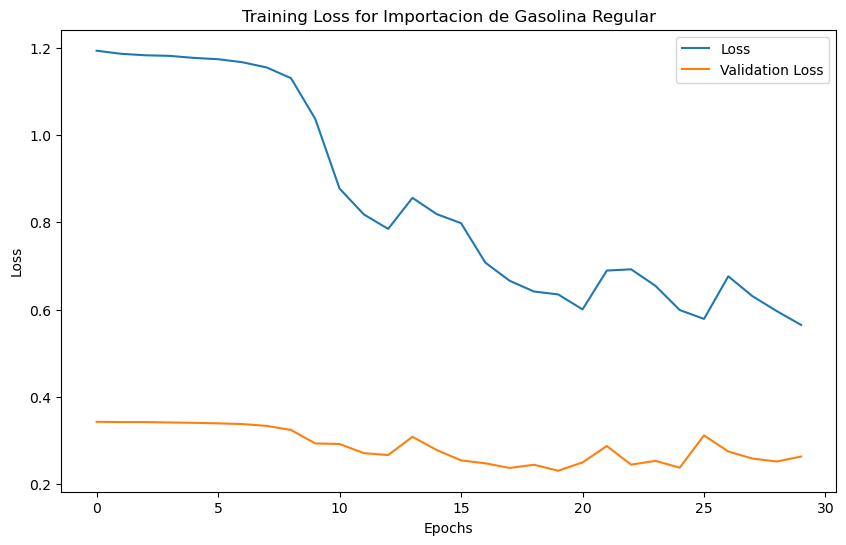

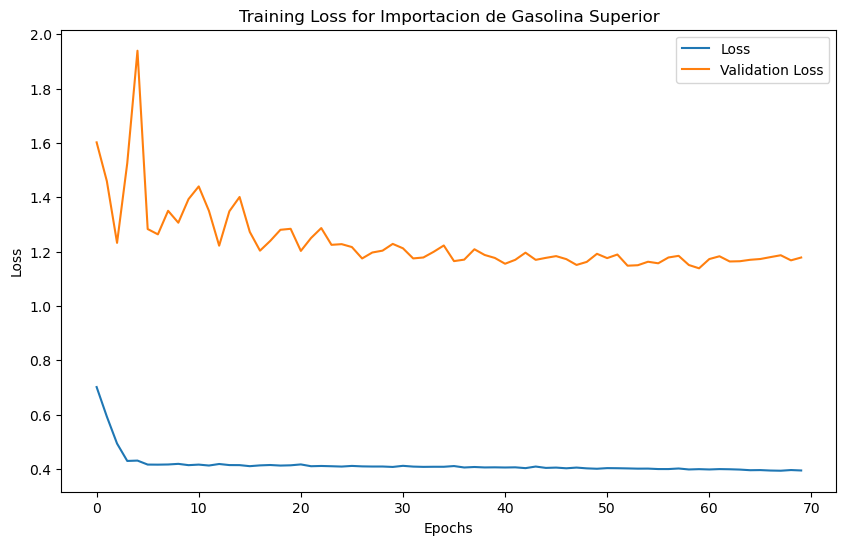

In [36]:
# Perdida Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_gas_licuado.history['loss'], label='Loss')
plt.plot(history_importacion_gas_licuado.history['val_loss'], label='Validation Loss')  
plt.title('Training Loss for Importacion de Gas Licuado')
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_diesel.history['loss'], label='Loss')
plt.plot(history_importacion_diesel.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Regular
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_regular.history['loss'], label='Loss')
plt.plot(history_importacion_regular.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Superior
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_superior.history['loss'], label='Loss')
plt.plot(history_importacion_superior.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Gasolina Superior')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluacion del Modelo
Evaluamos el modelo utilizando la métrica de Root Mean Squared Error (RMSE).

In [37]:
# Evaluacion Gas Licuado
y_pred_importacion_gas_licuado = model_importacion_gas_licuado.predict(X_test_importacion_gas_licuado)
rmse_importacion_gas_licuado = np.sqrt(mean_squared_error(y_test_importacion_gas_licuado, y_pred_importacion_gas_licuado))
print(f'RMSE for Importacion de Gas Licuado: {rmse_importacion_gas_licuado}')
print()

# Evaluacion Diesel
y_pred_importacion_diesel = model_importacion_diesel.predict(X_test_importacion_diesel)
rmse_importacion_diesel = np.sqrt(mean_squared_error(y_test_importacion_diesel, y_pred_importacion_diesel)) 
print(f'RMSE for Importacion de Diesel: {rmse_importacion_diesel}')
print()

# Evaluacion Regular
y_pred_importacion_regular = model_importacion_regular.predict(X_test_importacion_regular)
rmse_importacion_regular = np.sqrt(mean_squared_error(y_test_importacion_regular, y_pred_importacion_regular))
print(f'RMSE for Importacion de Gasolina Regular: {rmse_importacion_regular}')
print()

# Evaluacion Superior
y_pred_importacion_superior = model_importacion_superior.predict(X_test_importacion_superior)
rmse_importacion_superior = np.sqrt(mean_squared_error(y_test_importacion_superior, y_pred_importacion_superior))
print(f'RMSE for Importacion de Gasolina Superior: {rmse_importacion_superior}')

2/2 [==============================] - 0s 5ms/step
RMSE for Importacion de Gas Licuado: 0.45431032012367434

2/2 [==============================] - 0s 11ms/step
RMSE for Importacion de Diesel: 0.5153257797135377

2/2 [==============================] - 0s 6ms/step
RMSE for Importacion de Gasolina Regular: 0.4799620544646998

2/2 [==============================] - 0s 6ms/step
RMSE for Importacion de Gasolina Superior: 1.0670435249497925


#### Importacion
Aplicar el Tuneo de Parámetros a la Serie de Importacion

In [38]:
# Tuneo Gas Licuado
best_model_importacion_gas_licuado = tune_lstm_model(X_train_importacion_gas_licuado, y_train_importacion_gas_licuado, X_test_importacion_gas_licuado, y_test_importacion_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 102ms/step - loss: 1.1421 - val_loss: 0.6047
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1361 - val_loss: 0.6036
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1340 - val_loss: 0.6025
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1325 - val_loss: 0.6010
Epoch 5/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1274 - val_loss: 0.5993
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1234 - val_loss: 0.5973
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1156 - val_loss: 0.5939
Epoch 8/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1055 - val_loss: 0.5880
Epoch 9/50
7/7 [==============================] - 0s 29ms/step - loss: 1.0804 - val_loss: 0.5735
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 0.9957 - val_loss: 0.5243
Epoch 11/50
7/7 [===========

In [39]:
# Tuneo Diesel
best_model_importacion_diesel = tune_lstm_model(X_train_importacion_diesel, y_train_importacion_diesel, X_test_importacion_diesel, y_test_importacion_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 114ms/step - loss: 1.1670 - val_loss: 0.4108
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1628 - val_loss: 0.4098
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1577 - val_loss: 0.4085
Epoch 4/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1537 - val_loss: 0.4073
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1535 - val_loss: 0.4062
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 1.1448 - val_loss: 0.4039
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1370 - val_loss: 0.4011
Epoch 8/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1263 - val_loss: 0.3960
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 1.0911 - val_loss: 0.3847
Epoch 10/50
7/7 [==============================] - 0s 22ms/step - loss: 1.0283 - val_loss: 0.3595
Epoch 11/50
7/7 [===========

In [40]:
# Tuneo Regular
best_model_importacion_regular = tune_lstm_model(X_train_importacion_regular, y_train_importacion_regular, X_test_importacion_regular, y_test_importacion_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 99ms/step - loss: 1.1984 - val_loss: 0.3439
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1903 - val_loss: 0.3431
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1872 - val_loss: 0.3429
Epoch 4/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1861 - val_loss: 0.3419
Epoch 5/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1820 - val_loss: 0.3412
Epoch 6/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1798 - val_loss: 0.3403
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1754 - val_loss: 0.3391
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1684 - val_loss: 0.3365
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1583 - val_loss: 0.3333
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1406 - val_loss: 0.3271
Epoch 11/50
7/7 [============

In [41]:
# Tuneo Superior
best_model_importacion_superior = tune_lstm_model(X_train_importacion_superior, y_train_importacion_superior, X_test_importacion_superior, y_test_importacion_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 105ms/step - loss: 0.7164 - val_loss: 1.6390
Epoch 2/50
7/7 [==============================] - 0s 33ms/step - loss: 0.6348 - val_loss: 1.5125
Epoch 3/50
7/7 [==============================] - 0s 24ms/step - loss: 0.5429 - val_loss: 1.2694
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4482 - val_loss: 1.7073
Epoch 5/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4350 - val_loss: 2.7814
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4189 - val_loss: 1.3210
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4175 - val_loss: 1.2928
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4213 - val_loss: 1.4669
Epoch 9/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4197 - val_loss: 1.4420
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4149 - val_loss: 1.5689
Epoch 11/50
7/7 [===========

## Evaluacion
Utilizamos el mejor modelo para hacer predicciones y calculamos el RMSE.

In [42]:
# Evaluacion modelo Gas Licuado
y_pred_best_importacion_gas_licuado = best_model_importacion_gas_licuado.predict(X_test_importacion_gas_licuado)
best_rmse_importacion_gas_licuado = np.sqrt(mean_squared_error(y_test_importacion_gas_licuado, y_pred_best_importacion_gas_licuado))
print(f'Best RMSE for Importación de Gas Licuado after tuning: {best_rmse_importacion_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_best_importacion_diesel = best_model_importacion_diesel.predict(X_test_importacion_diesel)
best_rmse_importacion_diesel = np.sqrt(mean_squared_error(y_test_importacion_diesel, y_pred_best_importacion_diesel))
print(f'Best RMSE for Importación de Diesel after tuning: {best_rmse_importacion_diesel}')
print()

# Evaluacion modelo Regular
y_pred_best_importacion_regular = best_model_importacion_regular.predict(X_test_importacion_regular)
best_rmse_importacion_regular = np.sqrt(mean_squared_error(y_test_importacion_regular, y_pred_best_importacion_regular))
print(f'Best RMSE for Importación de Gasolina Regular after tuning: {best_rmse_importacion_regular}')
print()

# Evaluacion modelo Superior
y_pred_best_importacion_superior = best_model_importacion_superior.predict(X_test_importacion_superior)
best_rmse_importacion_superior = np.sqrt(mean_squared_error(y_test_importacion_superior, y_pred_best_importacion_superior))
print(f'Best RMSE for Importación de Gasolina Superior after tuning: {best_rmse_importacion_superior}')

2/2 [==============================] - 0s 6ms/step
Best RMSE for Importación de Gas Licuado after tuning: 0.4775169786408787

2/2 [==============================] - 0s 6ms/step
Best RMSE for Importación de Diesel after tuning: 0.522698201857168

2/2 [==============================] - 0s 7ms/step
Best RMSE for Importación de Gasolina Regular after tuning: 0.4875125088111542

2/2 [==============================] - 0s 7ms/step
Best RMSE for Importación de Gasolina Superior after tuning: 1.0879316772780496


### Guardar Modelo para la Serie Consumo

In [63]:
# Guardar los modelos
best_model_importacion_gas_licuado.save('BestModels/IMPORTACION-M1/best_model_importacion_gas_licuado.h5')
best_model_importacion_diesel.save('BestModels/IMPORTACION-M1/best_model_importacion_diesel.h5')
best_model_importacion_regular.save('BestModels/IMPORTACION-M1/best_model_importacion_regular.h5')
best_model_importacion_superior.save('BestModels/IMPORTACION-M1/best_model_importacion_superior.h5')

## Modelo LSTM #2 para la serie IMPORTACION
Definimos una función para crear un modelo LSTM con una arquitectura básica.... AQUI EMPEZAR EL MODELO 2

# SERIE PRECIOS

### Division de conjunto de datos
Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [43]:
# Division de los datos de precios
train_size = int(len(X_precios_gas_licuado) * 0.8)

# Gas Licuado
X_train_precios_gas_licuado, X_test_precios_gas_licuado = X_precios_gas_licuado[:train_size], X_precios_gas_licuado[train_size:]
y_train_precios_gas_licuado, y_test_precios_gas_licuado = y_precios_gas_licuado[:train_size], y_precios_gas_licuado[train_size:]

# Diesel
X_train_precios_diesel, X_test_precios_diesel = X_precios_diesel[:train_size], X_precios_diesel[train_size:]
y_train_precios_diesel, y_test_precios_diesel = y_precios_diesel[:train_size], y_precios_diesel[train_size:]

# Regular
X_train_precios_regular, X_test_precios_regular = X_precios_regular[:train_size], X_precios_regular[train_size:]
y_train_precios_regular, y_test_precios_regular = y_precios_regular[:train_size], y_precios_regular[train_size:]

# Superior
X_train_precios_superior, X_test_precios_superior = X_precios_superior[:train_size], X_precios_superior[train_size:]
y_train_precios_superior, y_test_precios_superior = y_precios_superior[:train_size], y_precios_superior[train_size:]

#### Entrenamiento para todos los combustibles
Entrenamos el modelo LSTM usando los datos de importacion.

In [44]:
# ya que el array es en 2D ajustamos la forma para que sea compatible con el modelo LSTM

# Precios Gas Licuado
if len(X_train_precios_gas_licuado.shape) == 2:
    X_train_precios_gas_licuado = np.expand_dims(X_train_precios_gas_licuado, axis=-1)
    X_test_precios_gas_licuado = np.expand_dims(X_test_precios_gas_licuado, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_gas_licuado: {X_train_precios_gas_licuado.shape}")

# Precios Diesel
if len(X_train_precios_diesel.shape) == 2:
    X_train_precios_diesel = np.expand_dims(X_train_precios_diesel, axis=-1)
    X_test_precios_diesel = np.expand_dims(X_test_precios_diesel, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_diesel: {X_train_precios_diesel.shape}")

# Precios Regular
if len(X_train_precios_regular.shape) == 2:
    X_train_precios_regular = np.expand_dims(X_train_precios_regular, axis=-1)
    X_test_precios_regular = np.expand_dims(X_test_precios_regular, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_regular: {X_train_precios_regular.shape}")

# Precios Superior
if len(X_train_precios_superior.shape) == 2:
    X_train_precios_superior = np.expand_dims(X_train_precios_superior, axis=-1)
    X_test_precios_superior = np.expand_dims(X_test_precios_superior, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_superior: {X_train_precios_superior.shape}")

Nuevas dimensiones de X_train_precios_gas_licuado: (25, 12, 1)
Nuevas dimensiones de X_train_precios_diesel: (25, 12, 1)
Nuevas dimensiones de X_train_precios_regular: (25, 12, 1)
Nuevas dimensiones de X_train_precios_superior: (25, 12, 1)


In [50]:
# Entrenamiento Gas Licuado
model_precios_gas_licuado = create_lstm_model((X_train_precios_gas_licuado.shape[1], X_train_precios_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_gas_licuado = model_precios_gas_licuado.fit(X_train_precios_gas_licuado, y_train_precios_gas_licuado, epochs=100, validation_data=(X_test_precios_gas_licuado, y_test_precios_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.0157 - val_loss: 1.0025
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 1.0058 - val_loss: 1.0308
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 0.9960 - val_loss: 1.0598
Epoch 4/100
1/1 [==============================] - 0s 61ms/step - loss: 0.9863 - val_loss: 1.0905
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.9766 - val_loss: 1.1219
Epoch 6/100
1/1 [==============================] - 0s 67ms/step - loss: 0.9671 - val_loss: 1.1543
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 0.9574 - val_loss: 1.1900
Epoch 8/100
1/1 [==============================] - 0s 64ms/step - loss: 0.9477 - val_loss: 1.2285
Epoch 9/100
1/1 [==============================] - 0s 66ms/step - loss: 0.9382 - val_loss: 1.2696
Epoch 10/100
1/1 [==============================] - 0s 65ms/step - loss: 0.9286 - val_loss: 1.3131
Epoch 11/100
1/1 [===

In [51]:
# Entrenamiento Diesel
model_precios_diesel = create_lstm_model((X_train_precios_diesel.shape[1], X_train_precios_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_diesel = model_precios_diesel.fit(X_train_precios_diesel, y_train_precios_diesel, epochs=100, validation_data=(X_test_precios_diesel, y_test_precios_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.5974 - val_loss: 0.1413
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5945 - val_loss: 0.1398
Epoch 3/100
1/1 [==============================] - 0s 52ms/step - loss: 1.5922 - val_loss: 0.1390
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 1.5900 - val_loss: 0.1385
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 1.5881 - val_loss: 0.1384
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 1.5863 - val_loss: 0.1385
Epoch 7/100
1/1 [==============================] - 0s 56ms/step - loss: 1.5845 - val_loss: 0.1387
Epoch 8/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5826 - val_loss: 0.1390
Epoch 9/100
1/1 [==============================] - 0s 61ms/step - loss: 1.5807 - val_loss: 0.1394
Epoch 10/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5788 - val_loss: 0.1400
Epoch 11/100
1/1 [===

In [52]:
# Entrenamiento Regular
model_precios_regular = create_lstm_model((X_train_precios_regular.shape[1], X_train_precios_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_regular = model_precios_regular.fit(X_train_precios_regular, y_train_precios_regular, epochs=100, validation_data=(X_test_precios_regular, y_test_precios_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.8463 - val_loss: 0.1067
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.8233 - val_loss: 0.1053
Epoch 3/100
1/1 [==============================] - 0s 66ms/step - loss: 0.8008 - val_loss: 0.1043
Epoch 4/100
1/1 [==============================] - 0s 70ms/step - loss: 0.7789 - val_loss: 0.1039
Epoch 5/100
1/1 [==============================] - 0s 66ms/step - loss: 0.7575 - val_loss: 0.1042
Epoch 6/100
1/1 [==============================] - 0s 70ms/step - loss: 0.7372 - val_loss: 0.1050
Epoch 7/100
1/1 [==============================] - 0s 85ms/step - loss: 0.7180 - val_loss: 0.1064
Epoch 8/100
1/1 [==============================] - 0s 67ms/step - loss: 0.6997 - val_loss: 0.1085
Epoch 9/100
1/1 [==============================] - 0s 60ms/step - loss: 0.6814 - val_loss: 0.1116
Epoch 10/100
1/1 [==============================] - 0s 81ms/step - loss: 0.6632 - val_loss: 0.1159
Epoch 11/100
1/1 [===

In [53]:
# Entrenamiento Superior
model_precios_superior = create_lstm_model((X_train_precios_superior.shape[1], X_train_precios_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_superior = model_precios_superior.fit(X_train_precios_superior, y_train_precios_superior, epochs=100, validation_data=(X_test_precios_superior, y_test_precios_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.8327 - val_loss: 0.1148
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: 0.8098 - val_loss: 0.1107
Epoch 3/100
1/1 [==============================] - 0s 59ms/step - loss: 0.7890 - val_loss: 0.1072
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 0.7710 - val_loss: 0.1046
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 0.7549 - val_loss: 0.1027
Epoch 6/100
1/1 [==============================] - 0s 64ms/step - loss: 0.7402 - val_loss: 0.1011
Epoch 7/100
1/1 [==============================] - 0s 60ms/step - loss: 0.7259 - val_loss: 0.0997
Epoch 8/100
1/1 [==============================] - 0s 62ms/step - loss: 0.7114 - val_loss: 0.0985
Epoch 9/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6967 - val_loss: 0.0975
Epoch 10/100
1/1 [==============================] - 0s 59ms/step - loss: 0.6819 - val_loss: 0.0969
Epoch 11/100
1/1 [===

#### Perdida
Graficamos la pérdida (loss) durante el entrenamiento para evaluar el rendimiento del modelo.

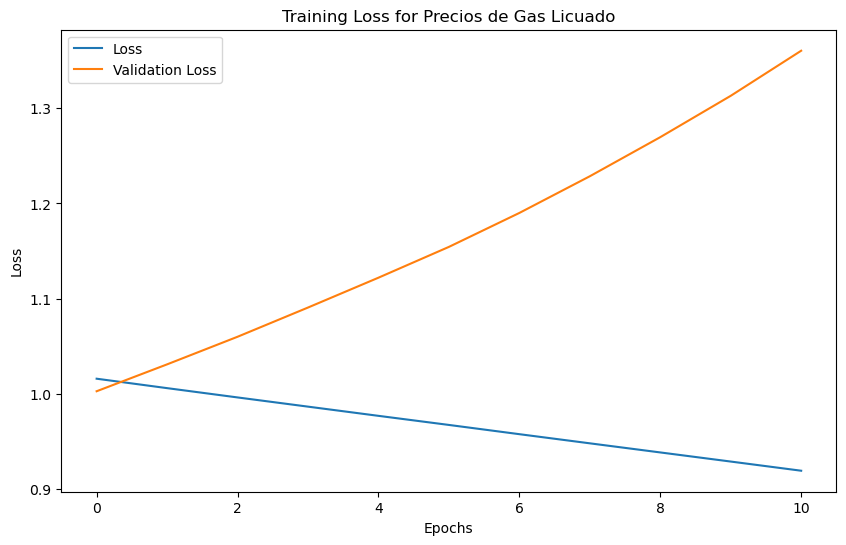

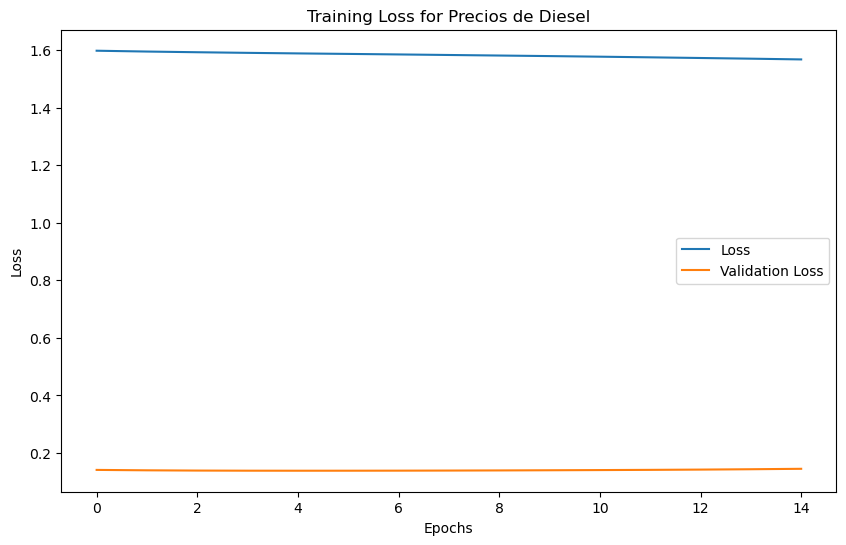

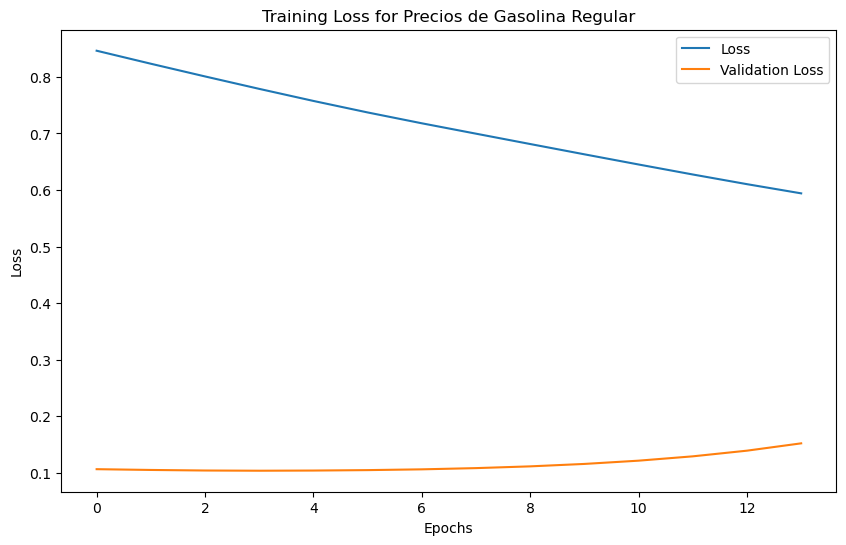

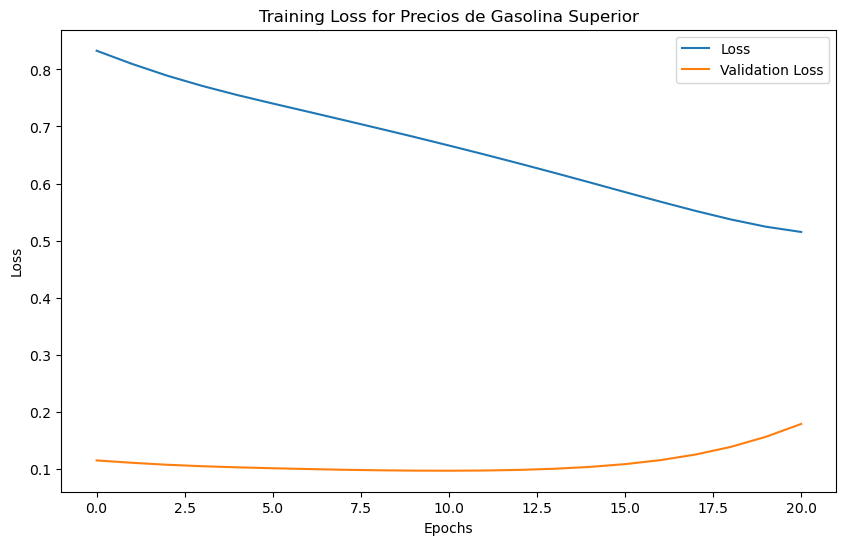

In [54]:
# Perdida Precios Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_precios_gas_licuado.history['loss'], label='Loss')
plt.plot(history_precios_gas_licuado.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Gas Licuado')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Precios Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_precios_diesel.history['loss'], label='Loss')
plt.plot(history_precios_diesel.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Precios Regular
plt.figure(figsize=(10, 6))
plt.plot(history_precios_regular.history['loss'], label='Loss')
plt.plot(history_precios_regular.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Precios Superior
plt.figure(figsize=(10, 6))
plt.plot(history_precios_superior.history['loss'], label='Loss')
plt.plot(history_precios_superior.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Gasolina Superior')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluacion del Modelo
Evaluamos el modelo utilizando la métrica de Root Mean Squared Error (RMSE).

In [55]:
# Evaluacion Gas Licuado
y_pred_precios_gas_licuado = model_precios_gas_licuado.predict(X_test_precios_gas_licuado)
rmse_precios_gas_licuado = np.sqrt(mean_squared_error(y_test_precios_gas_licuado, y_pred_precios_gas_licuado))
print(f'RMSE for Precios de Gas Licuado: {rmse_precios_gas_licuado}')
print()

# Evaluacion Diesel
y_pred_precios_diesel = model_precios_diesel.predict(X_test_precios_diesel)
rmse_precios_diesel = np.sqrt(mean_squared_error(y_test_precios_diesel, y_pred_precios_diesel))
print(f'RMSE for Precios de Diesel: {rmse_precios_diesel}')
print()

# Evaluacion Regular
y_pred_precios_regular = model_precios_regular.predict(X_test_precios_regular)
rmse_precios_regular = np.sqrt(mean_squared_error(y_test_precios_regular, y_pred_precios_regular))
print(f'RMSE for Precios de Gasolina Regular: {rmse_precios_regular}')
print()

# Evaluacion Superior
y_pred_precios_superior = model_precios_superior.predict(X_test_precios_superior)
rmse_precios_superior = np.sqrt(mean_squared_error(y_test_precios_superior, y_pred_precios_superior))
print(f'RMSE for Precios de Gasolina Superior: {rmse_precios_superior}')

1/1 [==============================] - 0s 379ms/step
RMSE for Precios de Gas Licuado: 1.0012454797385546

1/1 [==============================] - 0s 410ms/step
RMSE for Precios de Diesel: 0.3720491256332982

1/1 [==============================] - 2s 2s/step
RMSE for Precios de Gasolina Regular: 0.3223828291554725

1/1 [==============================] - 0s 428ms/step
RMSE for Precios de Gasolina Superior: 0.31104678665316576


#### Precios
Aplicar el Tuneo de Parámetros a la Serie de Precios

In [56]:
# Tuneo Gas Licuado
best_model_precios_gas_licuado = tune_lstm_model(X_train_precios_gas_licuado, y_train_precios_gas_licuado, X_test_precios_gas_licuado, y_test_precios_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.9897 - val_loss: 1.0474
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 0.9800 - val_loss: 1.0820
Epoch 3/50
1/1 [==============================] - 0s 52ms/step - loss: 0.9700 - val_loss: 1.1205
Epoch 4/50
1/1 [==============================] - 0s 55ms/step - loss: 0.9597 - val_loss: 1.1631
Epoch 5/50
1/1 [==============================] - 0s 55ms/step - loss: 0.9491 - val_loss: 1.2098
Epoch 6/50
1/1 [==============================] - 0s 59ms/step - loss: 0.9382 - val_loss: 1.2594
Epoch 7/50
1/1 [==============================] - 0s 112ms/step - loss: 0.9272 - val_loss: 1.3133
Epoch 8/50
1/1 [==============================] - 0s 58ms/step - loss: 0.9162 - val_loss: 1.3722
Epoch 9/50
1/1 [==============================] - 0s 58ms/step - loss: 0.9050 - val_loss: 1.4367
Epoch 10/50
1/1 [==============================] - 0s 57ms/step - loss: 0.8936 - val_loss: 1.5068
Epoch 11/50
1/1 [=============

In [57]:
# Tuneo Diesel
best_model_precios_diesel = tune_lstm_model(X_train_precios_diesel, y_train_precios_diesel, X_test_precios_diesel, y_test_precios_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 1.5986 - val_loss: 0.1436
Epoch 2/50
1/1 [==============================] - 0s 58ms/step - loss: 1.5946 - val_loss: 0.1409
Epoch 3/50
1/1 [==============================] - 0s 57ms/step - loss: 1.5914 - val_loss: 0.1386
Epoch 4/50
1/1 [==============================] - 0s 59ms/step - loss: 1.5887 - val_loss: 0.1371
Epoch 5/50
1/1 [==============================] - 0s 61ms/step - loss: 1.5865 - val_loss: 0.1361
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 1.5844 - val_loss: 0.1357
Epoch 7/50
1/1 [==============================] - 0s 60ms/step - loss: 1.5822 - val_loss: 0.1355
Epoch 8/50
1/1 [==============================] - 0s 60ms/step - loss: 1.5802 - val_loss: 0.1357
Epoch 9/50
1/1 [==============================] - 0s 60ms/step - loss: 1.5782 - val_loss: 0.1362
Epoch 10/50
1/1 [==============================] - 0s 58ms/step - loss: 1.5762 - val_loss: 0.1368
Epoch 11/50
1/1 [==============

In [58]:
# Tuneo Regular
best_model_precios_regular = tune_lstm_model(X_train_precios_regular, y_train_precios_regular, X_test_precios_regular, y_test_precios_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.8699 - val_loss: 0.1093
Epoch 2/50
1/1 [==============================] - 0s 74ms/step - loss: 0.8520 - val_loss: 0.1077
Epoch 3/50
1/1 [==============================] - 0s 183ms/step - loss: 0.8357 - val_loss: 0.1066
Epoch 4/50
1/1 [==============================] - 0s 84ms/step - loss: 0.8202 - val_loss: 0.1057
Epoch 5/50
1/1 [==============================] - 0s 69ms/step - loss: 0.8050 - val_loss: 0.1051
Epoch 6/50
1/1 [==============================] - 0s 67ms/step - loss: 0.7907 - val_loss: 0.1046
Epoch 7/50
1/1 [==============================] - 0s 64ms/step - loss: 0.7773 - val_loss: 0.1043
Epoch 8/50
1/1 [==============================] - 0s 75ms/step - loss: 0.7642 - val_loss: 0.1041
Epoch 9/50
1/1 [==============================] - 0s 75ms/step - loss: 0.7512 - val_loss: 0.1042
Epoch 10/50
1/1 [==============================] - 0s 73ms/step - loss: 0.7381 - val_loss: 0.1046
Epoch 11/50
1/1 [=============

In [59]:
# Tuneo Superior
best_model_precios_superior = tune_lstm_model(X_train_precios_superior, y_train_precios_superior, X_test_precios_superior, y_test_precios_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.8341 - val_loss: 0.1146
Epoch 2/50
1/1 [==============================] - 0s 63ms/step - loss: 0.8098 - val_loss: 0.1099
Epoch 3/50
1/1 [==============================] - 0s 68ms/step - loss: 0.7874 - val_loss: 0.1061
Epoch 4/50
1/1 [==============================] - 0s 63ms/step - loss: 0.7661 - val_loss: 0.1032
Epoch 5/50
1/1 [==============================] - 0s 59ms/step - loss: 0.7464 - val_loss: 0.1008
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 0.7282 - val_loss: 0.0988
Epoch 7/50
1/1 [==============================] - 0s 60ms/step - loss: 0.7105 - val_loss: 0.0971
Epoch 8/50
1/1 [==============================] - 0s 61ms/step - loss: 0.6931 - val_loss: 0.0959
Epoch 9/50
1/1 [==============================] - 0s 65ms/step - loss: 0.6760 - val_loss: 0.0952
Epoch 10/50
1/1 [==============================] - 0s 66ms/step - loss: 0.6590 - val_loss: 0.0951
Epoch 11/50
1/1 [==============

## Evaluacion
Utilizamos el mejor modelo para hacer predicciones y calculamos el RMSE.

In [60]:
# Evaluacion modelo Gas Licuado
y_pred_best_precios_gas_licuado = best_model_precios_gas_licuado.predict(X_test_precios_gas_licuado)
best_rmse_precios_gas_licuado = np.sqrt(mean_squared_error(y_test_precios_gas_licuado, y_pred_best_precios_gas_licuado))
print(f'Best RMSE for Precios de Gas Licuado after tuning: {best_rmse_precios_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_best_precios_diesel = best_model_precios_diesel.predict(X_test_precios_diesel)
best_rmse_precios_diesel = np.sqrt(mean_squared_error(y_test_precios_diesel, y_pred_best_precios_diesel))
print(f'Best RMSE for Precios de Diesel after tuning: {best_rmse_precios_diesel}')  
print()

# Evaluacion modelo Regular
y_pred_best_precios_regular = best_model_precios_regular.predict(X_test_precios_regular)
best_rmse_precios_regular = np.sqrt(mean_squared_error(y_test_precios_regular, y_pred_best_precios_regular))
print(f'Best RMSE for Precios de Gasolina Regular after tuning: {best_rmse_precios_regular}')
print()

# Evaluacion modelo Superior
y_pred_best_precios_superior = best_model_precios_superior.predict(X_test_precios_superior) 
best_rmse_precios_superior = np.sqrt(mean_squared_error(y_test_precios_superior, y_pred_best_precios_superior))
print(f'Best RMSE for Precios de Gasolina Superior after tuning: {best_rmse_precios_superior}') 

1/1 [==============================] - 0s 22ms/step
Best RMSE for Precios de Gas Licuado after tuning: 1.0128057401690407

1/1 [==============================] - 0s 32ms/step
Best RMSE for Precios de Diesel after tuning: 0.36516940134960885

1/1 [==============================] - 0s 33ms/step
Best RMSE for Precios de Gasolina Regular after tuning: 0.32267179387880335

1/1 [==============================] - 0s 35ms/step
Best RMSE for Precios de Gasolina Superior after tuning: 0.30808678638558007


### Guardar Modelo para la Serie Precios

In [62]:
# Guardar los modelos
best_model_precios_gas_licuado.save('BestModels/PRECIOS-M1/best_model_precios_gas_licuado.h5')
best_model_precios_diesel.save('BestModels/PRECIOS-M1/best_model_precios_diesel.h5')
best_model_precios_regular.save('BestModels/PRECIOS-M1/best_model_precios_regular.h5')
best_model_precios_superior.save('BestModels/PRECIOS-M1/best_model_precios_superior.h5')  

## Modelo LSTM #2 para la serie PRECIOS
Definimos una función para crear un modelo LSTM con una arquitectura básica.... AQUI EMPEZAR EL MODELO 2